#### CSC 180  Intelligent Systems (Fall 2021)

#### Dr. Haiquan Chen, Dept of Computer Scicence

#### California State University, Sacramento



## Lab 10: Regularization and Feature Importance Analysis


# Helpful Functions for Tensorflow (Little Gems)

The following functions will be used with TensorFlow to help preprocess the data.  They allow you to build the feature vector for a neural network. 

* Predictors/Inputs 
    * Fill any missing inputs with the median for that column.  Use **missing_median**.
    * Encode textual/categorical values with **encode_text_dummy**.
    * Encode numeric values with **encode_numeric_zscore**.
* Output
    * Discard rows with missing outputs.
    * Encode textual/categorical values with **encode_text_index**.
    * Do not encode output numeric values.
* Produce final feature vectors (x) and expected output (y) with **to_xy**.

In [1]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low



# L1 and L2 regularization techniques used in linear regression

L1 and L2 regularization are two common regularization techniques.

We are going to look at linear regression to see how L1 and L2 regularization work.  The following code sets up the auto-mpg data for this purpose.

https://www.kaggle.com/uciml/autompg-dataset/home

The labeling on the origin column is 1 for domestic, 2 for Europe and 3 for Asia

They are used to avoid overfitting

In [2]:
from sklearn.linear_model import LassoCV
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from sklearn.model_selection import train_test_split 

path = "./data/"

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])
df[0:20]

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino
5,15.0,8,429.0,198.0,4341,10.0,70,1,ford galaxie 500
6,14.0,8,454.0,220.0,4354,9.0,70,1,chevrolet impala
7,14.0,8,440.0,215.0,4312,8.5,70,1,plymouth fury iii
8,14.0,8,455.0,225.0,4425,10.0,70,1,pontiac catalina
9,15.0,8,390.0,190.0,3850,8.5,70,1,amc ambassador dpl


In [3]:
# create feature vector
missing_median(df, 'horsepower')
df.drop('name', 1, inplace=True)

encode_text_dummy(df, 'origin')
df[0:20]

/tmp/ipykernel_369908/1183005336.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df.drop('name', 1, inplace=True)


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin-1,origin-2,origin-3
0,18.0,8,307.0,130.0,3504,12.0,70,1,0,0
1,15.0,8,350.0,165.0,3693,11.5,70,1,0,0
2,18.0,8,318.0,150.0,3436,11.0,70,1,0,0
3,16.0,8,304.0,150.0,3433,12.0,70,1,0,0
4,17.0,8,302.0,140.0,3449,10.5,70,1,0,0
5,15.0,8,429.0,198.0,4341,10.0,70,1,0,0
6,14.0,8,454.0,220.0,4354,9.0,70,1,0,0
7,14.0,8,440.0,215.0,4312,8.5,70,1,0,0
8,14.0,8,455.0,225.0,4425,10.0,70,1,0,0
9,15.0,8,390.0,190.0,3850,8.5,70,1,0,0


In [4]:
# Encode to a 2D matrix for training
x,y = to_xy(df,'mpg')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=45) 

# Naive Linear Regression

To understand L1/L2 regularization, it is good to start with linear regression.  L1/L2 were first introduced for [linear regression](https://en.wikipedia.org/wiki/Linear_regression).  They can also be used for neural networks.  

The following code uses linear regression to fit the auto-mpg data set.  The RMSE reported will not be as good as a neural network.

In [5]:
import sklearn
from sklearn.linear_model import LinearRegression

# Create linear regression
regressor = LinearRegression()

# Fit/train linear regression
regressor.fit(x_train,y_train)

# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))

print("Final score (RMSE): {}".format(score))

Final score (RMSE): 2.937157392501831


In [6]:
names = list(df.columns.values)

print(names)

['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin-1', 'origin-2', 'origin-3']


In [7]:
regressor.coef_
# Useful for telling which features are important and which are not

array([-0.41654855,  0.0244562 , -0.00778463, -0.00747326,  0.13812254,
        0.80127406, -1.4483734 ,  0.8185649 ,  0.62980866], dtype=float32)

In [8]:
regressor.intercept_

-18.257532

In [9]:
# Simple function to evaluate the coefficients of a regression

%matplotlib inline    
from IPython.display import display   

def report_coef(names,coef,intercept):
    r = pd.DataFrame( { 'coef': coef, 'positive': coef>=0  }, index = names )
    r = r.sort_values(by=['coef'])
    display(r)
    print("Intercept: {}".format(intercept))
    r['coef'].plot(kind='barh', color=r['positive'].map({True: 'b', False: 'r'}))

,coef,positive
origin-1,-1.448373,False
cylinders,-0.416549,False
horsepower,-0.007785,False
weight,-0.007473,False
displacement,0.024456,True
acceleration,0.138123,True
origin-3,0.629809,True
year,0.801274,True
origin-2,0.818565,True


Intercept: -18.257532119750977


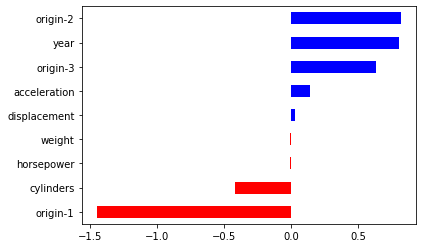

In [10]:
names.remove("mpg")

report_coef(
  names,
  regressor.coef_,
  regressor.intercept_)

# L1 (Lasso) Regularization

L1 Regularization, also called LASSO (Least Absolute Shrinkage and Selection Operator) should be used to create sparsity in the neural network. 

### L1 algorithm will push many weight connections to near 0.  

When a weight is near 0, the program drops it from the network.  Dropping weighted connections will create a sparse neural network.

### The lower weight values will typically lead to less overfitting.


### Minimization objective = SSE (Sum of Squared Error) + $\alpha$ * (Sum of Absolute Value of Coefficients)

When $\alpha$ is 0, Lasso regression produces the same coefficients as a linear regression. When $\alpha$ is very very large, all coefficients are zero.

The following code demonstrates lasso regression.  Notice the effect of the coefficients compared to the previous section that used linear regression.

Final score (RMSE): 3.0409061908721924


,coef,positive
origin-1,-1.264469,False
weight,-0.007458,False
horsepower,-0.002797,False
cylinders,-0.000000,True
origin-2,0.000000,True
origin-3,0.000000,True
displacement,0.013005,True
acceleration,0.113762,True
year,0.787195,True


Intercept: -17.271318435668945


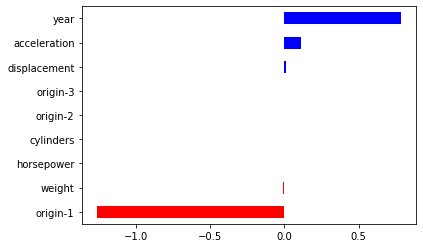

In [11]:
import sklearn
from sklearn.linear_model import Lasso

# Create linear regression
regressor = Lasso(alpha=0.1)

# Fit/train LASSO
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df.columns.values)
names.remove("mpg")

report_coef(
  names,
  regressor.coef_,
  regressor.intercept_)

### Note:  If your data set has a large number of input features that may not be needed, L1 regularization can help to detect and ignore unnecessary features.

# L2 (Ridge) Regularization

Use Ridge/L2 regularization when you prefer low weight values.  ***The lower weight values will typically lead to less overfitting.*** 


### Minimization objective = SSE (Sum of Squared Error) + $\alpha$ * (Sum of Square of Coefficients)

When $\alpha$ is 0, L2 regression produces the same coefficients as a linear regression. When $\alpha$ is very very large, all coefficients are zero.

### L1 will force the weights into a pattern similar to a laplace distribution; the L2 will force the weights into a pattern similar to a Gaussian distribution***, as demonstrated the following:

![L1 vs L2](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_9_l1_l2.png "L1 vs L2")


The following code uses L2 with linear regression (Ridge regression):

Final score (RMSE): 2.937575578689575


/usr/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.88494e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


,coef,positive
origin-1,-1.444143,False
cylinders,-0.415849,False
horsepower,-0.007759,False
weight,-0.007473,False
displacement,0.024423,True
acceleration,0.138105,True
origin-3,0.630158,True
year,0.801221,True
origin-2,0.818294,True


Intercept: -18.256078720092773


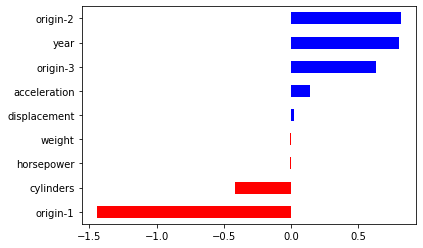

In [12]:
import sklearn
from sklearn.linear_model import Ridge

# Create linear regression
regressor = Ridge(alpha=0.1)

# Fit/train Ridge
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df.columns.values)
names.remove("mpg")

report_coef(
  names,
  regressor.coef_,
  regressor.intercept_)

## ElasticNet:   Linear regression with mixing L1 with L2.  
    
* $\alpha$: Constant for penalty (regularization). 
    
* l1_ratio : The ElasticNet mixing parameter, with 0 <= l1_ratio <= 1. For l1_ratio = 0 the penalty is an L2 penalty. For l1_ratio = 1 it is an L1 penalty.


#### If you want the following:  a $*$ L1 + b $*$ L2,   set $\alpha$ = a + b and l1_ratio = a / (a + b)

Final score (RMSE): 3.031985282897949


,coef,positive
origin-1,-0.938925,False
cylinders,-0.257572,False
weight,-0.007462,False
horsepower,-0.002896,False
displacement,0.017533,True
acceleration,0.131321,True
origin-3,0.369088,True
origin-2,0.458725,True
year,0.788913,True


Intercept: -17.480127334594727


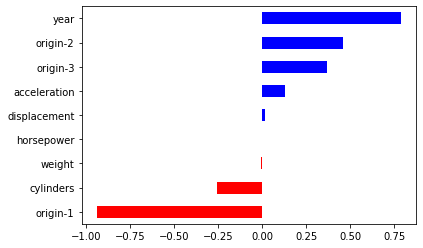

In [13]:
import sklearn
from sklearn.linear_model import ElasticNet

# Create linear regression
regressor = ElasticNet(alpha=0.1, l1_ratio=0.1)

# Fit/train ElasticNet
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df.columns.values)
names.remove("mpg")

report_coef(
  names,
  regressor.coef_,
  regressor.intercept_)

# You can also apply such L1/L2 to get the feature importance for a classification problem.   This can be done by training a Logistic Regression model and observe the coefficient learned for each feature.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html


#### The following is the sample code, which is just a little bit different than the way we did before for regression.  In this code, we remove y-intercept.   Note you should define x_train, y_train, x_test, y_test first to run the code.  





In [14]:
import sklearn
from sklearn.linear_model import LogisticRegression

# Create linear regression
regressor = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=.1)

# Fit/train linear regression
regressor.fit(x_train,y_train)

ValueError: Unknown label type: 'continuous'

In [15]:
# Simple function to evaluate the coefficients of a classification

def report_coef(names,coef):
    r = pd.DataFrame( { 'coef': coef, 'positive': coef>=0  }, index = names )
    r = r.sort_values(by=['coef'])
    display(r)
    r['coef'].plot(kind='barh', color=r['positive'].map({True: 'b', False: 'r'}))  


In [16]:
# Create the plot for the importance of each feature

names.remove("your_output_feature_goes_here")

report_coef(
  names,
  regressor.coef_[0])

ValueError: list.remove(x): x not in list

#  L1/L2 in TensorFlow?

L1 and L2 regularization work by adding a weight penalty to the neural network training.  

### This penalty push the connection weights to small values.

In [17]:
########################################
# TensorFlow with L1/L2 for Regression
########################################
%matplotlib inline
from matplotlib.pyplot import figure, show
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential

path = "./data/"


filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

df.drop('name',1,inplace=True)
missing_median(df, 'horsepower')
encode_text_dummy(df, 'origin')
x,y = to_xy(df,"mpg")

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=45)

model = Sequential()

/tmp/ipykernel_369908/244091398.py:23: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df.drop('name',1,inplace=True)
2021-10-04 11:05:28.366660: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-10-04 11:05:28.366753: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (alec-xps13): /proc/driver/nvidia/version does not exist
2021-10-04 11:05:28.369845: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### You can set three regularization params for Dense, Conv1D, Conv2D and Conv3D. 

keras.layers.Dense(units, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)


***kernel_regularizer***: Regularizer function applied to the kernel weights matrix. kernel regularizer will constantly decay the weights.

***activity_regularizer***: Regularizer function applied to the output of the layer.  Activity regularizer will tend to make the output of the layer smaller.

***bias_regularizer***: Regularizer function applied to the bias vector.

https://keras.io/regularizers/

In [18]:
model.add(Dense(50, input_dim=x.shape[1], activation='relu'))
model.add(Dense(25, activation='relu'))

model.add(Dense(10, 
                kernel_regularizer=regularizers.l1(0.01),
                activity_regularizer=regularizers.l2(0.01), activation='relu'))


In [19]:
model.add(Dense(1))   #  output layer

model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=100)

pred = model.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

2021-10-04 11:05:28.452580: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
10/10 - 0s - loss: 15422.7715 - val_loss: 10209.0342
Epoch 2/100
10/10 - 0s - loss: 5926.5015 - val_loss: 4126.1670
Epoch 3/100
10/10 - 0s - loss: 3761.9946 - val_loss: 2306.7207
Epoch 4/100
10/10 - 0s - loss: 2321.3237 - val_loss: 1899.0872
Epoch 5/100
10/10 - 0s - loss: 1636.8881 - val_loss: 1429.6461
Epoch 6/100
10/10 - 0s - loss: 1232.8116 - val_loss: 1028.6028
Epoch 7/100
10/10 - 0s - loss: 947.4642 - val_loss: 767.8094
Epoch 8/100
10/10 - 0s - loss: 729.9977 - val_loss: 588.6902
Epoch 9/100
10/10 - 0s - loss: 570.3315 - val_loss: 456.7469
Epoch 10/100
10/10 - 0s - loss: 456.1638 - val_loss: 361.1597
Epoch 11/100
10/10 - 0s - loss: 370.1435 - val_loss: 289.5148
Epoch 12/100
10/10 - 0s - loss: 296.2598 - val_loss: 203.9222
Epoch 13/100
10/10 - 0s - loss: 192.7819 - val_loss: 126.2074
Epoch 14/100
10/10 - 0s - loss: 145.4973 - val_loss: 105.6864
Epoch 15/100
10/10 - 0s - loss: 122.6487 - val_loss: 90.7810
Epoch 16/100
10/10 - 0s - loss: 108.8521 - val_loss: 79.5542
Epoch

# Dropout Layer  (A dedicated layer for regularization)

#### Each dropout layer will drop neurons in its previous layer.

***To create a dropout layer, specify dropout probability.***  The dropout probability indicates the likelihood of a neuron dropping out for every batch during training. Typically this value is 0.1 to 0.5. 

***Actually, a certain percentage of neurons will be masked during each training iteration.  All neurons return after training is complete.*** 


Animation that shows how [dropout works](https://yusugomori.com/projects/deep-learning/dropout-relu)

#### A dropout layer can be added between any two hidden layers to reduce overfitting. 

# TensorFlow Code with Dropout 

In [24]:
############################################
# TensorFlow with Dropout for Regression
############################################


import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential

path = "./data/"


filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

df.drop('name',1,inplace=True)

missing_median(df, 'horsepower')

encode_text_dummy(df, 'origin')

df[0:20]

/tmp/ipykernel_369908/3165991113.py:24: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df.drop('name',1,inplace=True)


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin-1,origin-2,origin-3
0,18.0,8,307.0,130.0,3504,12.0,70,1,0,0
1,15.0,8,350.0,165.0,3693,11.5,70,1,0,0
2,18.0,8,318.0,150.0,3436,11.0,70,1,0,0
3,16.0,8,304.0,150.0,3433,12.0,70,1,0,0
4,17.0,8,302.0,140.0,3449,10.5,70,1,0,0
5,15.0,8,429.0,198.0,4341,10.0,70,1,0,0
6,14.0,8,454.0,220.0,4354,9.0,70,1,0,0
7,14.0,8,440.0,215.0,4312,8.5,70,1,0,0
8,14.0,8,455.0,225.0,4425,10.0,70,1,0,0
9,15.0,8,390.0,190.0,3850,8.5,70,1,0,0


In [25]:
x,y = to_xy(df,"mpg")

In [26]:
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=45)

model = Sequential()
model.add(Dense(50, input_dim=x.shape[1]))
model.add(Dropout(0.1))

model.add(Dense(25, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)

pred = model.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

Epoch 1/1000
10/10 - 0s - loss: 254542.5312 - val_loss: 21280.7402
Epoch 2/1000
10/10 - 0s - loss: 16532.5254 - val_loss: 15670.0098
Epoch 3/1000
10/10 - 0s - loss: 9504.4922 - val_loss: 712.7132
Epoch 4/1000
10/10 - 0s - loss: 7526.7373 - val_loss: 652.9702
Epoch 5/1000
10/10 - 0s - loss: 6178.0259 - val_loss: 503.0488
Epoch 6/1000
10/10 - 0s - loss: 5332.0439 - val_loss: 385.2239
Epoch 7/1000
10/10 - 0s - loss: 4290.3291 - val_loss: 499.9599
Epoch 8/1000
10/10 - 0s - loss: 4418.4155 - val_loss: 612.4316
Epoch 9/1000
10/10 - 0s - loss: 4315.7339 - val_loss: 624.3520
Epoch 10/1000
10/10 - 0s - loss: 4775.9580 - val_loss: 1320.2142
Epoch 11/1000
10/10 - 0s - loss: 3467.8394 - val_loss: 2149.9863
Epoch 00011: early stopping
Final score (RMSE): 46.36794662475586


In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                500       
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                260       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 2,046
Trainable params: 2,046
Non-trainable params: 0
_________________________________________________________________


### Reflection:  How 500 and 1275 were calcuated?

1275 = 50*25 + 25

### References:

* [Google Colab](https://colab.research.google.com/) - Free web based platform that includes Python, Juypter Notebooks, and TensorFlow with free GPU support.  No setup needed.
* [IBM Cognitive Class Labs](https://www.datascientistworkbench.com) - Free web based platform that includes Python, Juypter Notebooks, and TensorFlow.  No setup needed.
* [Python Anaconda](https://www.continuum.io/downloads) - Python distribution that includes many data science packages, such as Numpy, Scipy, Scikit-Learn, Pandas, and much more.
* [TensorFlow](https://www.tensorflow.org/) - Google's mathematics package for deep learning.
* [Kaggle](https://www.kaggle.com/) - Competitive data science.  Good source of sample data.
* T81-558: Applications of Deep Neural Networks. Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/)